<div class='alert alert-success'>
    <h1>Qiskit Tutorial, Part 3: Arithmetic </h1>
    <h4>Yen Lee Loh; started 2023-4-5, edited 2023-4-7 </h4>
</div>

<div class="alert alert-info"><h2>  Setup  </h2></div>

This is a Markdown cell with LaTeX definitions.  Please run it.
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$

In [1]:
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()

def toBitString(integer, numBits): return bin(integer)[2:].zfill(numBits)
def plotStateVector(psi,ax,cmap=mpl.cm.hsv):
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  for l in range(lmax):
    patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
    ax.add_patch(patch)
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, max(probs)*1.1)
def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {toBitString(i,n):sanitize(cts.get(toBitString(i,n))) for i in range(2**n)}
def plotHistogram(counts,ax,fc='#9cf',textrot=0):
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )  # ugly
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  ymax = max(counts)
  for l in range(lmax):
    c = counts[l]
    patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
    ax.add_patch(patch)
    if c>0:
      y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
      ax.text (l+.5, y, c, va='center',ha='center')
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])  
  ax.tick_params(axis='x', labelrotation=textrot)
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, ymax*1.02)

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator

#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine

<div class="alert alert-info"><h2>  Reversible 4-bit increment: predefined input </h2></div>

In [9]:
def initState (cir, value, numBits):
  for i in range(numBits):
    if (value>>i)&1:
      cir.x(i)

Enter a binary number between 0000 and 1111, then press Enter:  1101


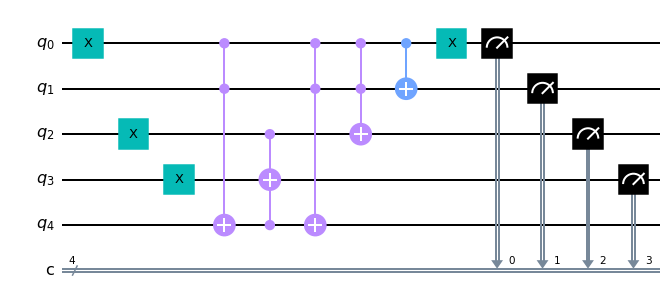

In [13]:
inputString = input('Enter a binary number between 0000 and 1111, then press Enter: ')
cir = qiskit.QuantumCircuit(5,4)
initState (cir, value=int(inputString,2), numBits=4)
cir.ccx(0,1,4); cir.ccx(2,4,3); cir.ccx(0,1,4) # q3 ^= q0&q1&q2 (using ancilla q_4)
cir.ccx(0,1,2)                                 # q2 ^= q0&q1
cir.cx(0,1)                                    # q1 ^= q0
cir.x(0)                                       # q0 ^= 1
cir.measure([0,1,2,3], [0,1,2,3])              # measure q0,q1,q2,q3 and store in c0,c1,c2,c3
cir.draw('mpl', justify='none')

In [14]:
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=1)
res = job.result()
cts = res.get_counts(exe)
print('Input  = ', inputString)
print('Output = ', cts)
print('\nIf the circuit executed correctly, the output should equal the input plus one.')

Input  =  1101
Output =  {'1110': 1}

If the circuit executed correctly, the output should equal the input plus one.


<div class="alert alert-info"><h2>  Reversible 4-bit increment: superposition of some input states </h2></div>

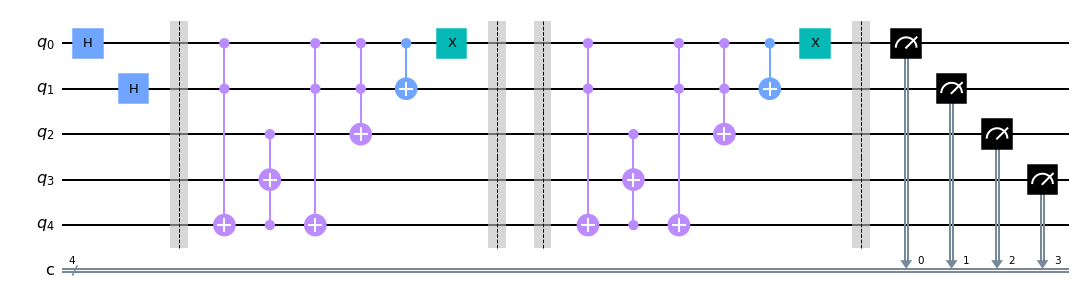

In [22]:
cir = qiskit.QuantumCircuit(5,4)
cir.h(0); cir.h(1)                             # generate |0000>+|0001>+|0010>+|0011>
cir.barrier()
cir.ccx(0,1,4); cir.ccx(2,4,3); cir.ccx(0,1,4) # q3 ^= q0&q1&q2 (using ancilla q_4)
cir.ccx(0,1,2)                                 # q2 ^= q0&q1
cir.cx(0,1)                                    # q1 ^= q0
cir.x(0)                                       # q0 ^= 1
cir.barrier()
cir.barrier()
cir.ccx(0,1,4); cir.ccx(2,4,3); cir.ccx(0,1,4) # q3 ^= q0&q1&q2 (using ancilla q_4)
cir.ccx(0,1,2)                                 # q2 ^= q0&q1
cir.cx(0,1)                                    # q1 ^= q0
cir.x(0)                                       # q0 ^= 1
cir.barrier()
cir.measure([0,1,2,3], [0,1,2,3])              # measure q0,q1,q2,q3 and store in c0,c1,c2,c3
cir.draw('mpl', justify='none')

counts =  {'0100': 1}

The two Hadamard gates initialize the quantum computer to |0>+|1>+|2>+|3>.
The increment operation changes the state to              |1>+|2>+|3>+|4>.
The measurements should return 1, 2, 3, or 4 with equal probability.


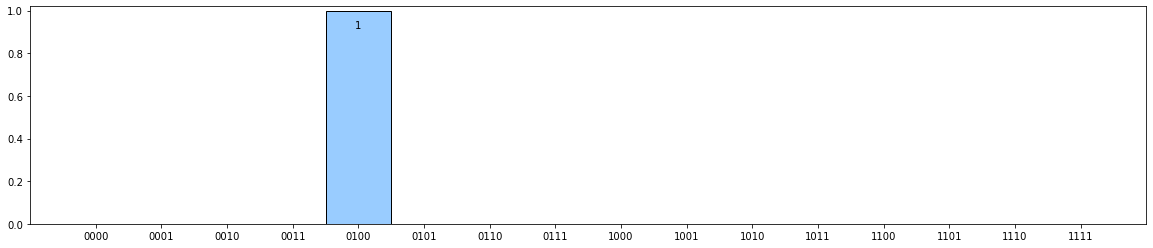

In [32]:
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=1)
result = job.result()
counts = result.get_counts(exe)
print('counts = ', counts)
print ('')
print('The two Hadamard gates initialize the quantum computer to |0>+|1>+|2>+|3>.')
print('The increment operation changes the state to              |1>+|2>+|3>+|4>.')
print('The measurements should return 1, 2, 3, or 4 with equal probability.')
fig,ax=plt.subplots(figsize=(20,4))
plotHistogram (counts, ax)

<div class="alert alert-info"><h2>  2-bit multiplier: superposition of all input states  </h2></div>

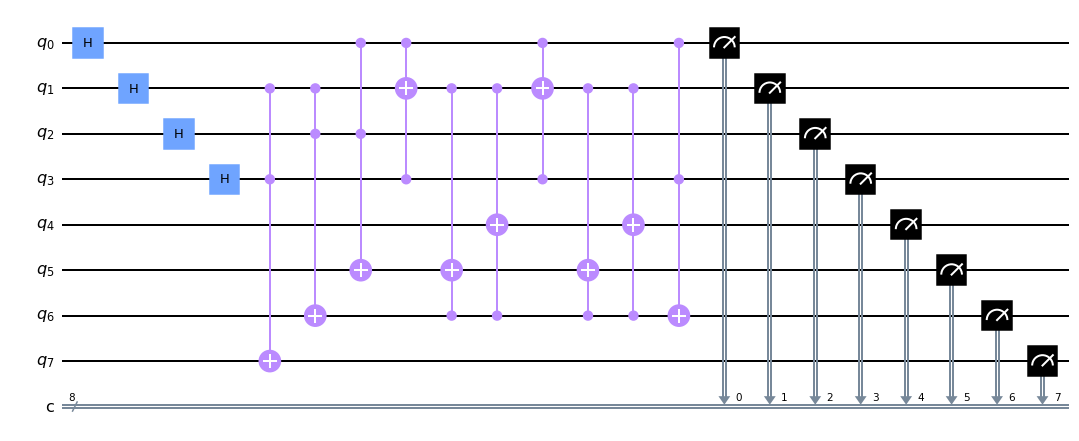

In [7]:
cir = qiskit.QuantumCircuit(8,8)
#======== Generate uniform superposition
cir.h(0); cir.h(1); cir.h(2); cir.h(3)
#======== Multiply input registers [0,1] and [2,3] to give output register [4,5,6,7] using ancilla-free circuit
cir.ccx(1,3,7)
cir.ccx(1,2,6)
cir.ccx(0,2,5)
cir.ccx(0,3,1)
cir.ccx(1,6,5)
cir.ccx(1,6,4)
cir.ccx(0,3,1)
cir.ccx(1,6,5)
cir.ccx(1,6,4)
cir.ccx(0,3,6)
#======== Measure everything
cir.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7])   # Measure q0,q1,q2,q3 and store in c0,c1,c2,c3
cir.draw('mpl', justify='none')

In [8]:
exe = qiskit.transpile(cir, sim)
job = sim.run(exe, shots=10)
res = job.result()
cts = res.get_counts(exe)
print('Output = ', cts)
print('\nThe quantum computer has performed the following multiplication operations in parallel:\n')
for output in cts.keys():
  output = output[::-1]
  print (f'  Output bits q0...q7 = {output}      {output[0:2]} * {output[2:4]} = {output[4:8]}')

Output =  {'00001000': 2, '01100111': 1, '10011111': 1, '01000110': 1, '01101101': 1, '11001110': 1, '00000001': 1, '00001100': 1, '00000100': 1}

The quantum computer has performed the following multiplication operations in parallel:

  Output bits q0...q7 = 00010000      00 * 01 = 0000
  Output bits q0...q7 = 11100110      11 * 10 = 0110
  Output bits q0...q7 = 11111001      11 * 11 = 1001
  Output bits q0...q7 = 01100010      01 * 10 = 0010
  Output bits q0...q7 = 10110110      10 * 11 = 0110
  Output bits q0...q7 = 01110011      01 * 11 = 0011
  Output bits q0...q7 = 10000000      10 * 00 = 0000
  Output bits q0...q7 = 00110000      00 * 11 = 0000
  Output bits q0...q7 = 00100000      00 * 10 = 0000


<div class="alert alert-info" style="background-color: #FF9; border-color: #CC6;"><h2>  Suggested activities  </h2></div>

3.1.  Subtractive exploration
- Take the above code and simplify it, e.g., to do reversible 3-bit increment.
